Since the whole Enron dataset is able to fit in RAM, Dask's main use is to speed up computation on the dataset.
1. Load data
2. Tokenization

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import dask.dataframe as dd
from distributed import Client
import numpy as np

In [2]:
client = Client(processes = True)
client.cluster

In [3]:
#Load Data produced by Data_Wrangling notebook. 
#PICKLE_LOC = "../data/dataframes/wrangled_enron_df.pkl" #Single Mailbox
ENRON_PICKLE_LOC = "../data/dataframes/wrangled_enron_full_df.pkl"
BC3_EMAIL_PICKLE_LOC = "../data/dataframes/wrangled_BC3_email_df.pkl"
BC3_SUMMARY_PICKLE_LOC = "../data/dataframes/wrangled_BC3_summary_df.pkl"
#Load into dask dataframe to speed up processing of the whole Enron dataset. 
enron_df = dd.from_pandas(pd.read_pickle(ENRON_PICKLE_LOC), npartitions=10)

#The following datasets are small enough to not require dask. 
BC3_emails_df = pd.read_pickle(BC3_EMAIL_PICKLE_LOC)
BC3_summary_df = pd.read_pickle(BC3_SUMMARY_PICKLE_LOC)

In [4]:
#Let data persist in memory
enron_df = client.persist(enron_df)

In [5]:
#Overview of the Enron dataframe. 
enron_df.head(3)

,Body,Chain,Date,Email Folder,Employee,From,Full_Email_Path,Message-ID,Signature,Subject,Extractive_Sentences,Tokenized_Body
0,yep. looks like i found the formula.,\nFrom: \tErin Richardson <erichardson@sarofim...,2001-10-12 15:23:48,sent_items,lenhart-m,matthew.lenhart@enron.com,../data/maildir/lenhart-m/sent_items/511.,<5562353.1075854977892.JavaMail.evans@thyme>,None,RE:,"[yep., looks like i found the formula.]","[yep, looks like found formula]"
1,sorry i had to run last night. so the word is ...,\nFrom: \tHal Lenhart <Hal.Lenhart@apollogrp.e...,2001-10-26 14:24:43,sent_items,lenhart-m,matthew.lenhart@enron.com,../data/maildir/lenhart-m/sent_items/414.,<2305015.1075854975015.JavaMail.evans@thyme>,None,RE:,"[sorry i had to run last night., so the word i...","[sorry run last night, word enron companies lo..."
2,"i tried to call yesterday, but you guys were n...",None,2001-05-14 17:55:00,sent_items,lenhart-m,matthew.lenhart@enron.com,../data/maildir/lenhart-m/sent_items/231.,<7740426.1075845207401.JavaMail.evans@thyme>,None,Re: MOTHER'S DAY,"[i tried to call yesterday, but you guys were ...","[tried call yesterday guys home, speak grandma..."


In [6]:
#Used to create a describe summary of the dataset. Ignoring tokenized columns. 
enron_df[['Body', 'Chain', 'Date', 'Email Folder', 'Employee', 'From', 'Full_Email_Path', 'Message-ID', 'Signature', 'Subject']].describe().compute()

,Body,Chain,Date,Email Folder,Employee,From,Full_Email_Path,Message-ID,Signature,Subject
unique,204479,84330,182120,1076,150,19299,204479,204479,11103,135824
count,204479,89632,204478,204479,204479,204479,204479,204479,26361,197056
top, > A married man left work early one Friday a...,:' line.\n\nYou may also contact this person f...,2001-06-27 23:02:00,deleted_items,dasovich-j,jeff.dasovich@enron.com,../data/maildir/zufferli-j/sent_items/99.,<9999931.1075852407238.JavaMail.evans@thyme>,"Best,\nJeff",RE:
freq,1,73,652,29400,13901,4706,1,1,1213,4495
first,NaN,NaN,1980-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2024-05-26 10:49:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
enron_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, Body to Tokenized_Body
dtypes: datetime64[ns](1), object(11)

In [8]:
#Look at the range of dates the emails are from. 
start_date = str(enron_df.Date.min().compute())
end_date =  str(enron_df.Date.max().compute())
print("Start Date: " + start_date)
print("End Date: " + end_date)

Start Date: 1980-01-01 00:00:00
End Date: 2024-05-26 10:49:57


In [9]:
#Since the data was collected in May 2002 according to wikipedia, its a bit strange to see emails past that date. 

In [10]:
enron_df[(enron_df['Date'] > '2003-01-01')].compute()

,Body,Chain,Date,Email Folder,Employee,From,Full_Email_Path,Message-ID,Signature,Subject,Extractive_Sentences,Tokenized_Body
7466,Thank you for subscribing to Ann Taylor email ...,None,2004-02-04 01:43:53,deleted_items,geaccone-t,clientservices@anntaylor.com,../data/maildir/geaccone-t/deleted_items/156.,<13518335.1075859033546.JavaMail.evans@thyme>,None,Ann Taylor Subscription Confirmation,[Thank you for subscribing to Ann Taylor email...,[thank subscribing ann taylor email news welco...
98618,How Would you like to look and feel 1020 years...,None,2005-12-29 10:14:21,deleted_items,kaminski-v,johansc2924@picko.tandoori.demon.co.uk,../data/maildir/kaminski-v/deleted_items/1061.,<26304473.1075855462808.JavaMail.evans@thyme>,None,Look-and-feel-10-20-years-younger,[How Would you like to look and feel 1020 year...,"[would like look feel years younger, would int..."
157366,You have requested an authorization code to va...,None,2004-02-04 02:19:15,deleted_items,pimenov-v,chaseonlineplus@chaseonline.chase.com,../data/maildir/pimenov-v/deleted_items/52.,<29939978.1075861155181.JavaMail.evans@thyme>,None,Your code,[You have requested an authorization code to v...,[requested authorization code validate device ...
167169,"If you are seeing this message, your email cli...",None,2004-02-04 02:41:50,inbox,zipper-a,1800flowers.215430146@s2u2.com,../data/maildir/zipper-a/inbox/256.,<29320735.1075862510488.JavaMail.evans@thyme>,None,SAVE 10%* on d?cor they'll adore!,"[If you are seeing this message, your email cl...","[seeing message email client support html, ple..."
167661,Bear in a Pumpkin Sweaterwith Candy Corn <http...,your friends at 1-800-FLOWERS.COM\n\nCall 1-8...,2004-02-03 23:39:00,deleted_items,zipper-a,1800flowers.200573461@s2u2.com,../data/maildir/zipper-a/deleted_items/482.,<13010275.1075851540341.JavaMail.evans@thyme>,None,Pre-order your Shrek(TM) gift set and purchase...,[Bear in a Pumpkin Sweaterwith Candy Corn <htt...,[bear pumpkin sweaterwith candy corn httpwwwfl...
197960,"Kim, My name is Molly Vaughan and I work along...",None,2004-02-04 01:43:23,inbox,donohoe-t,mvaughan@forrester.com,../data/maildir/donohoe-t/inbox/247.,<7937981.1075859003771.JavaMail.evans@thyme>,None,Forrester Research,"[Kim, My name is Molly Vaughan and I work alon...",[kim name molly vaughan work along side forres...
225759,Dear James Schwieger: <table width=550 border=...,None,2004-02-04 02:23:55,deleted_items,schwieger-j,announcement@popularlink.com,../data/maildir/schwieger-j/deleted_items/198.,<21915162.1075861435191.JavaMail.evans@thyme>,None,Limited-time Offer,[Dear James Schwieger: <table width=550 border...,[dear james schwieger table width border cellp...
232800,Celebrations Birthday Chocolate CandycakeTM <h...,your friends at 1-800-FLOWERS.COM\n\nCall 1-8...,2004-02-04 02:17:46,deleted_items,corman-s,1800flowers.243967005@s2u2.com,../data/maildir/corman-s/deleted_items/200.,<22653853.1075861066474.JavaMail.evans@thyme>,None,Gifts to make your January celebrations special!,[Celebrations Birthday Chocolate CandycakeTM <...,[celebrations birthday chocolate candycaketm h...
232834,Bear in a Pumpkin Sweaterwith Candy Corn <http...,your friends at 1-800-FLOWERS.COM\n\nCall 1-8...,2004-02-04 01:40:34,deleted_items,corman-s,1800flowers.199693062@s2u2.com,../data/maildir/corman-s/deleted_items/25.,<27129533.1075858834388.JavaMail.evans@thyme>,None,Pre-order your Shrek(TM) gift set and purchase...,[Bear in a Pumpkin Sweaterwith Candy Corn <htt...,[bear pumpkin sweaterwith candy corn httpwwwfl...
233014,What's New <http://www.s2u2.com/passthru.asp?r...,None,2004-02-04 01:40:36,deleted_items,corman-s,domestications.198273363@s2u2.com,../data/maildir/corman-s/deleted_items/61.,<19388631.1075858836543.JavaMail.evans@thyme>,None,Domestications Best Sellers,[What's New <http://www.s2u2.com/passthru.asp?...,[whats new httpwwwsucompassthruaspredirecturlh...


In [11]:
#The emails seem to be spam, and should be droped. 

In [12]:
#testing better parrallelization of code
def tokenize_word(sentences):
    tokens = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
    return tokens

In [13]:
#Tokenize the sentences 
enron_df['Tokenized_Words'] = enron_df['Tokenized_Body'].apply(tokenize_word).compute()

/home/kirt/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:2955: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Tokenized_Body', 'object'))

  warnings.warn(meta_warning(meta))


In [14]:
#Get word frequencies from tokenized word lists
def get_word_freq(df):
    freq_words=dict()
    for tokens in df.Tokenized_Words.compute():
        for token in tokens:
            if token in freq_words:
                freq_words[token] += 1
            else: 
                freq_words[token] = 1
    return freq_words     

In [15]:
#Creating word dictionary to understand word frequencies. 
freq_words = get_word_freq(enron_df)

In [16]:
print('Unique words: {:,}'.format(len(freq_words)))

Unique words: 96,664


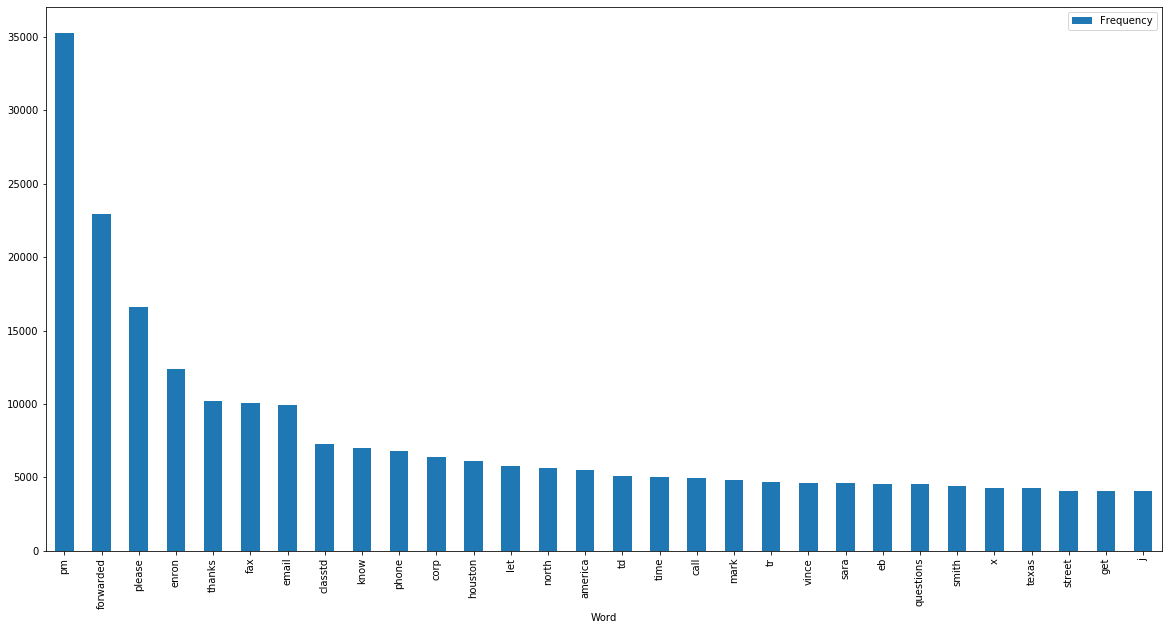

In [17]:
word_data = []
#Sort dictionary by highest word frequency. 
for key, value in sorted(freq_words.items(), key=lambda item: item[1], reverse=True):
    word_data.append([key, freq_words[key]])

#Prepare to plot bar graph of top words. 
#Create dataframe with Word and Frequency, then sort in Descending order. 
freq_words_df = pd.DataFrame.from_dict(freq_words, orient='index').reset_index()
freq_words_df = freq_words_df.rename(columns={"index": "Word", 0: "Frequency"})
freq_words_df = freq_words_df.sort_values(by=['Frequency'],ascending = False)
freq_words_df.reset_index(drop = True, inplace=True)
freq_words_df.head(30).plot(x='Word', kind='bar', figsize=(20,10))